---
**<font size="6">PROJECT : 
 Anticipate the electricity consumption needs of buildings </font>**


---
**Author : Alexis Marceau**

# Presentation and objectives

Recap of objectives :

1. Perform preliminary multivariate analysis to assess relationships between variables before modeling.
   
2. Predict CO₂ emissions and energy consumption of non-residential buildings in Seattle, supporting the city’s goal of achieving carbon neutrality by 2050. This is based on survey data from 2015 and 2016.
   
3. Evaluate the value of the "ENERGY STAR Score" in predicting CO₂ emissions and Energy, considering its high cost and complexity to calculate.
   
4. Test various prediction models to optimize accuracy in estimating energy consumption (SiteEnergyUse(kBtu)) and CO₂ emissions (TotalGHGEmissions).

# Libraries and display options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
%matplotlib inline 

#options d'affichages
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

#"turn-off" warnings
warnings.filterwarnings("ignore")

#show pipeline
from sklearn import set_config
set_config(display='diagram')

---

# Data loading

In [3]:
df = pd.read_pickle('df_cleaned.pickle')
print('Dimension du dataset nettoyé:')
print('Lignes: {}'.format(df.shape[0]) + ' \nColonnes: {}'.format(df.shape[1]))

Dimension du dataset nettoyé:
Lignes: 1696 
Colonnes: 24


In [4]:
df.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
0,325,2015,NonResidential,Retail store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,7,DOWNTOWN,47.611711,-122.336816,1989,Unknown,1.0,4.0,111077.0,91.0,9898724.0,69.01,0.24,1,1.00000,0.00000,111077.0,27769.25
1,400,2015,NonResidential,Small and midsized office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,7,DOWNTOWN,47.606799,-122.337100,1906,Office,1.0,6.0,98370.0,45.0,6525887.0,47.24,0.20,1,0.73651,0.26349,98370.0,16395.00


# More  EDA, cleaning and feature engineering

Removal of unnecessary columns relating to building identification or costly survey data.

In [5]:
df = df.drop(['OSEBuildingID','Address','PropertyName','GHGEmissionsIntensity'], axis=1) 

I create a new variable corresponding to the age of the building

In [6]:
df['BuildingAge'] = df['DataYear'] - df['YearBuilt'] 

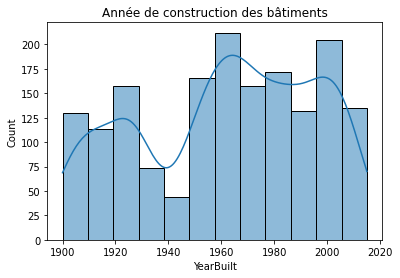

In [ ]:
sns.histplot(data=df, x="YearBuilt", kde=True)
plt.title('Année de construction des bâtiments')
plt.show()

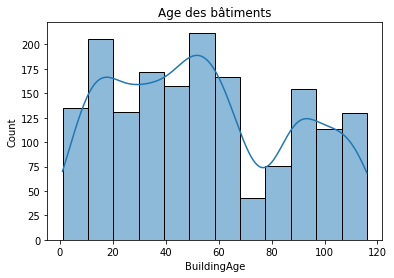

In [8]:
sns.histplot(data=df, x="BuildingAge", kde=True)
plt.title('Age des bâtiments')
plt.show()

In [9]:
df.dtypes.sort_values()

DataYear                    int64
TotalUseTypeNumber          int64
YearBuilt                   int64
BuildingAge                 int64
CouncilDistrictCode         int64
ENERGYSTARScore           float64
GFAPerBuilding            float64
GFAParkingRate            float64
GFABuildingRate           float64
TotalGHGEmissions         float64
SiteEnergyUse(kBtu)       float64
NumberofFloors            float64
GFAPerFloor               float64
NumberofBuildings         float64
Longitude                 float64
Latitude                  float64
PropertyGFATotal          float64
LargestPropertyUseType     object
BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
dtype: object

In [10]:
df.BuildingType.value_counts()

NonResidential        1487
SPS-District K-12       98
Nonresidential COS      85
Campus                  25
Nonresidential WA        1
Name: BuildingType, dtype: int64

In this section, we're creating transformed versions of the PropertyGFATotal feature to capture different relationships with the target

In [11]:
df['PropertyGFATotal_log'] =  np.log(df['PropertyGFATotal']) 
df['PropertyGFATotal_sqrt'] =  np.sqrt(df['PropertyGFATotal'])
df['PropertyGFATotal_square'] =  np.square(df['PropertyGFATotal'])

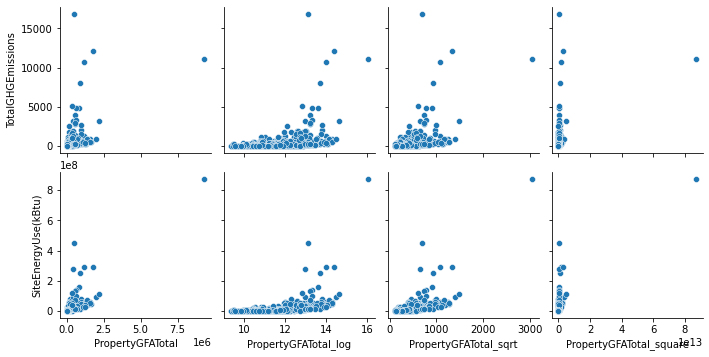

In [12]:
sns.pairplot(
    df,
    x_vars=["PropertyGFATotal",'PropertyGFATotal_log','PropertyGFATotal_sqrt','PropertyGFATotal_square'],
    y_vars=['TotalGHGEmissions','SiteEnergyUse(kBtu)'],
)

 the log and square root transformations seem to improve the spread and may be more useful for modeling, as they reduce skewness and highlight linear relationships with the target variables.

 **In the next few cells we will remove some more outliers :**

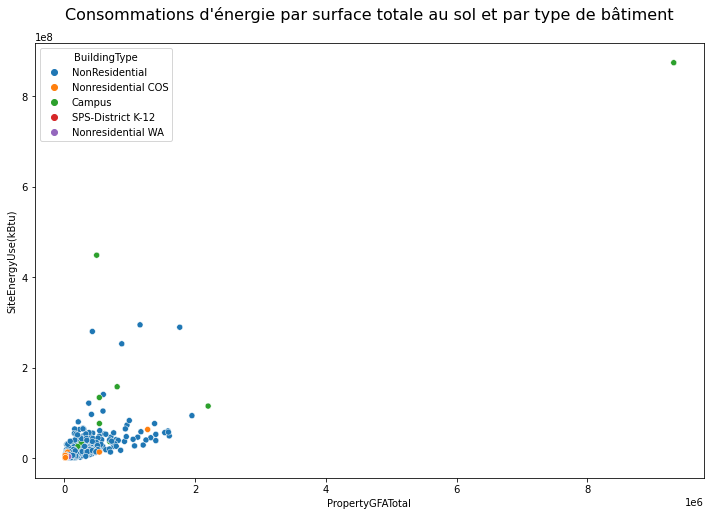

In [13]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n", fontsize=16)
plt.show()

We remove the outlier on the right corner (green data point) by filtering 

In [14]:
df[df['SiteEnergyUse(kBtu)']>8*1e8]

,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,PropertyGFATotal_log,PropertyGFATotal_sqrt,PropertyGFATotal_square
1656,2016,Campus,University,4,NORTHEAST,47.65644,-122.31041,1900,College/University,111.0,1.0,9320156.0,72.5,873923712.0,11140.56,1,1.0,0.0,83965.369,9320156.0,116,16.04769,3052.893054,8.686531e+13


In [15]:
df = df[df['SiteEnergyUse(kBtu)']<8*1e8]

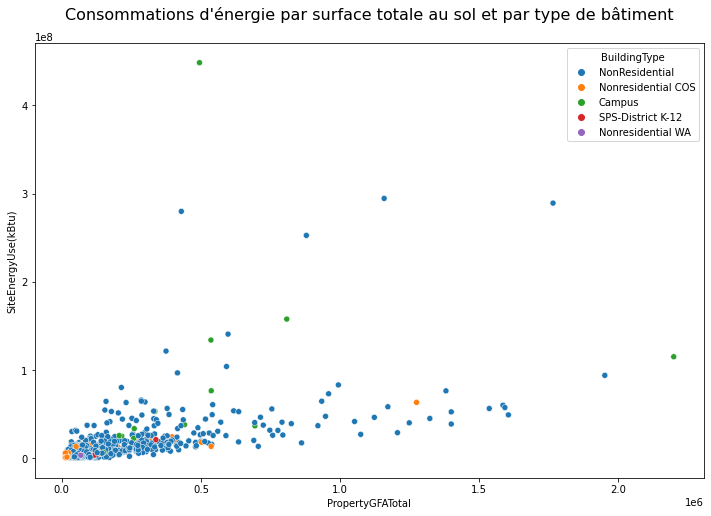

In [16]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n", fontsize=16)
plt.show()

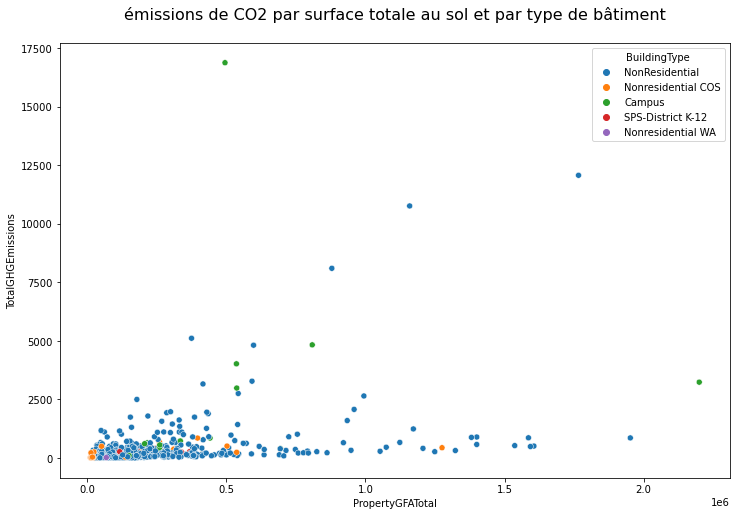

In [17]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='PropertyGFATotal', y='TotalGHGEmissions', hue='BuildingType')
plt.title(f"émissions de CO2 par surface totale au sol et par type de bâtiment\n", fontsize=16)
plt.show()

filters out buildings with `TotalGHGEmissions` above 1000. This selection aims to focus the analysis on the main cluster, potentially reducing the impact of extreme values and improving model performance by focusing on the more typical range of emissions.

In [18]:
df = df[df['TotalGHGEmissions']<1000]

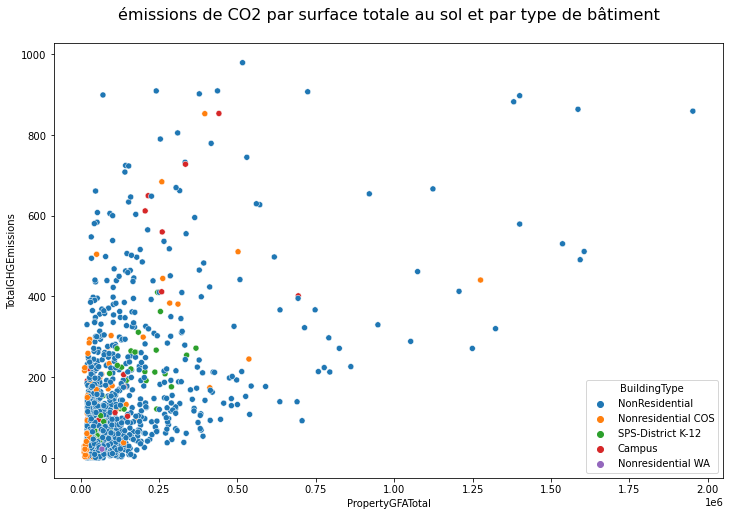

In [19]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='PropertyGFATotal', y='TotalGHGEmissions', hue='BuildingType')
plt.title(f"émissions de CO2 par surface totale au sol et par type de bâtiment\n", fontsize=16)
plt.show()

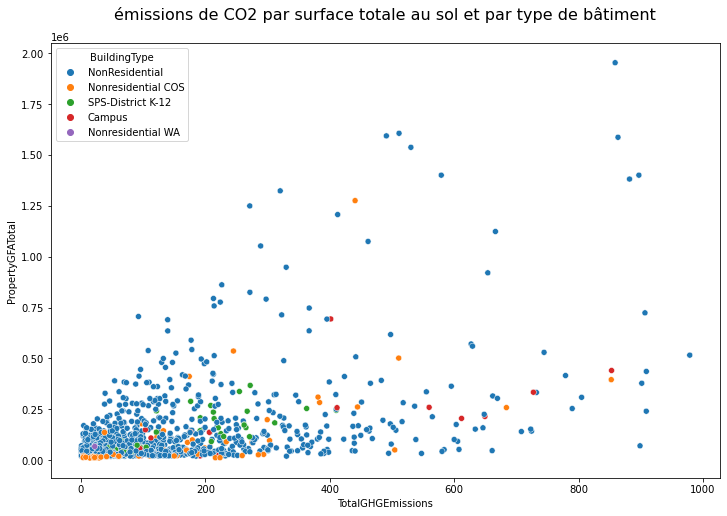

In [20]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='PropertyGFATotal', hue='BuildingType')
plt.title(f"émissions de CO2 par surface totale au sol et par type de bâtiment\n", fontsize=16)
plt.show()

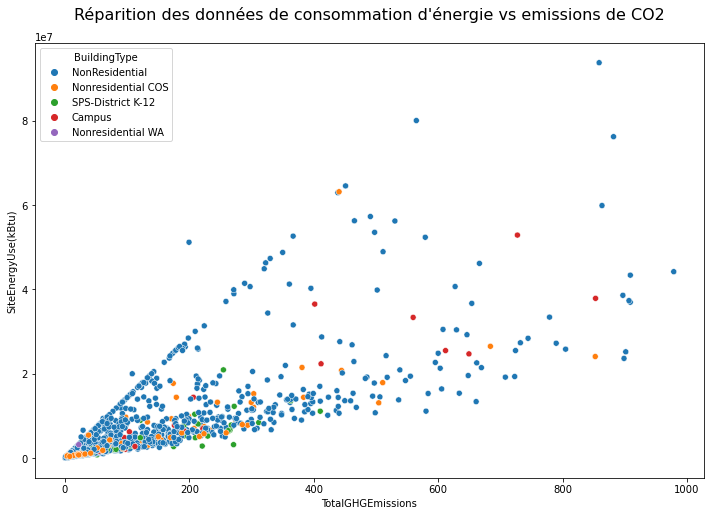

In [21]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Réparition des données de consommation d'énergie vs emissions de CO2\n", fontsize=16)
plt.show()

In [56]:
df[(df['SiteEnergyUse(kBtu)'] > 4*1e7) & (df['TotalGHGEmissions'] < 250)]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,PropertyGFATotal_log,PropertyGFATotal_sqrt,PropertyGFATotal_square,GFAPerBuilding_log,GFAPerBuilding_sqrt,GFAPerBuilding_square,GFAParkingRate_log,GFAParkingRate_sqrt,GFAParkingRate_square,GFABuildingRate_log,GFABuildingRate_sqrt,GFABuildingRate_square,GFAPerFloor_log,GFAPerFloor_sqrt,GFAPerFloor_square
1659,NonResidential,University,4,NORTHEAST,47.65356,-122.30613,1998,College/University,1.0,6.0,203030.0,72.5,51168308.0,199.48,1,1.0,0.0,203030.0,33838.333,18,12.221109,450.588504,4.122118e+10,12.221109,450.588504,4.122118e+10,0.0,0.0,0.0,0.0,1.0,1.0,10.42935,183.951986,1.145033e+09


In [57]:
df = df.drop(df[(df['SiteEnergyUse(kBtu)'] > 4*1e7) & (df['TotalGHGEmissions'] < 250)].index)

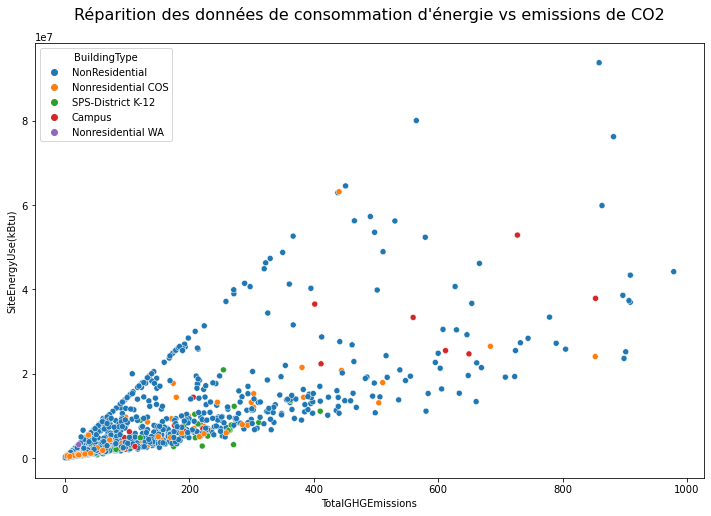

In [59]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Réparition des données de consommation d'énergie vs emissions de CO2\n", fontsize=16)
plt.show()

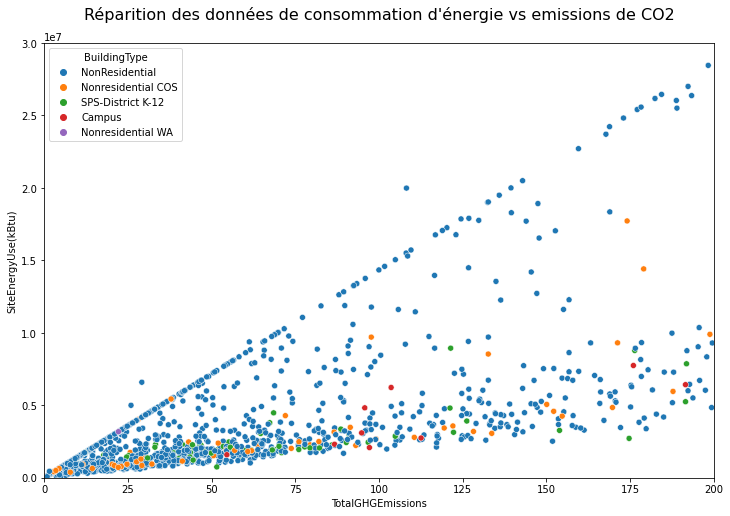

In [62]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Réparition des données de consommation d'énergie vs emissions de CO2\n", fontsize=16)
plt.ylim(0, 3*1e7)
plt.xlim(0, 200)
 
plt.show()

In [66]:
df[(df['SiteEnergyUse(kBtu)'] > 1.8*1e7) & (df['TotalGHGEmissions'] < 125)]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,PropertyGFATotal_log,PropertyGFATotal_sqrt,PropertyGFATotal_square,GFAPerBuilding_log,GFAPerBuilding_sqrt,GFAPerBuilding_square,GFAParkingRate_log,GFAParkingRate_sqrt,GFAParkingRate_square,GFABuildingRate_log,GFABuildingRate_sqrt,GFABuildingRate_square,GFAPerFloor_log,GFAPerFloor_sqrt,GFAPerFloor_square
619,NonResidential,Small and midsized office,1,DELRIDGE,47.54103,-122.33766,1929,Office,1.0,3.0,85126.0,50.0,19985481.0,108.2,1,1.0,0.0,85126.0,28375.333,87,11.351888,291.763603,7.246436e+09,11.351888,291.763603,7.246436e+09,0.0,0.0,0.0,0.0,1.0,1.0,10.253275,168.449794,8.051595e+08


In [67]:
df = df.drop(df[(df['SiteEnergyUse(kBtu)'] > 1.8*1e7) & (df['TotalGHGEmissions'] < 125)].index)

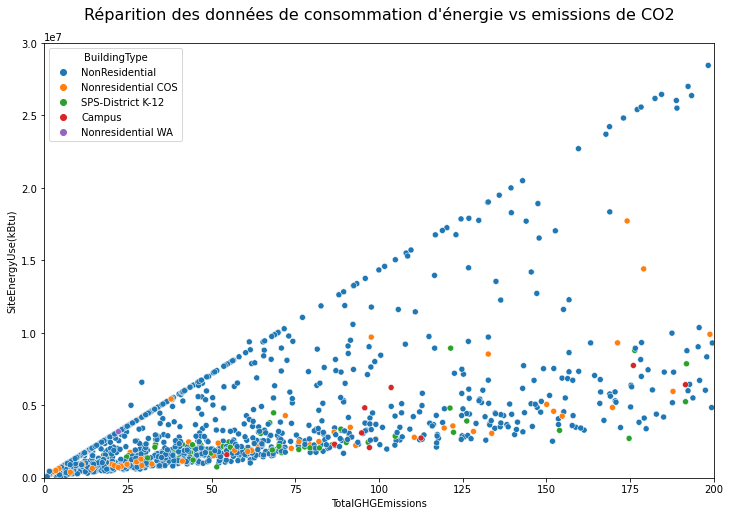

In [68]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Réparition des données de consommation d'énergie vs emissions de CO2\n", fontsize=16)
plt.ylim(0, 3*1e7)
plt.xlim(0, 200)
 
plt.show()

In [72]:
df[(df['SiteEnergyUse(kBtu)'] > 0.48*1e7) & (df['TotalGHGEmissions'] < 30)]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,PropertyGFATotal_log,PropertyGFATotal_sqrt,PropertyGFATotal_square,GFAPerBuilding_log,GFAPerBuilding_sqrt,GFAPerBuilding_square,GFAParkingRate_log,GFAParkingRate_sqrt,GFAParkingRate_square,GFABuildingRate_log,GFABuildingRate_sqrt,GFABuildingRate_square,GFAPerFloor_log,GFAPerFloor_sqrt,GFAPerFloor_square
471,NonResidential,Large office,2,DOWNTOWN,47.59878,-122.33458,1913,Office,3.0,7.0,154159.0,100.0,6593180.5,29.155,1,1.0,0.0,51386.333,22022.714,103,11.94574,392.630870,2.376500e+10,10.847128,226.685538,2.640555e+09,0.0,0.0,0.0,0.0,1.0,1.0,9.999830,148.400519,4.849999e+08
1657,NonResidential,University,4,NORTHEAST,47.65395,-122.30584,1969,College/University,1.0,4.0,58779.0,72.5,5000717.0,25.930,1,1.0,0.0,58779.000,14694.750,47,10.98154,242.443808,3.454971e+09,10.981540,242.443808,3.454971e+09,0.0,0.0,0.0,0.0,1.0,1.0,9.595246,121.221904,2.159357e+08


In [74]:
df = df.drop(df[(df['SiteEnergyUse(kBtu)'] > 0.48*1e7) & (df['TotalGHGEmissions'] < 30)].index)

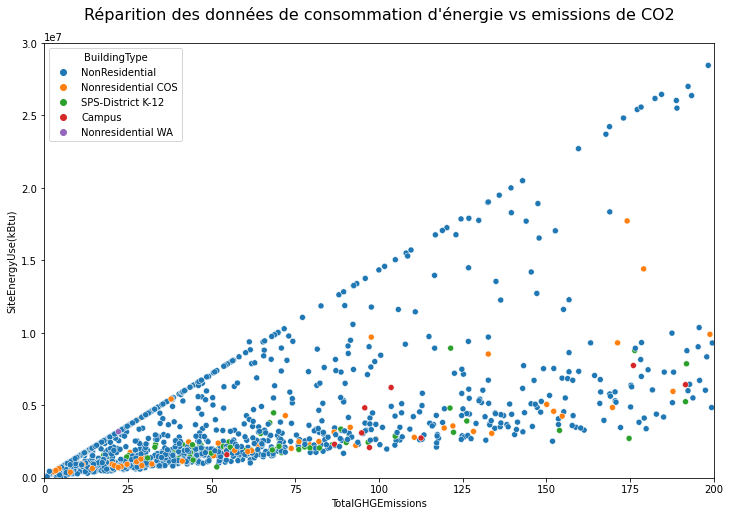

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Réparition des données de consommation d'énergie vs emissions de CO2\n", fontsize=16)
plt.ylim(0, 3*1e7)
plt.xlim(0, 200)
 
plt.show()

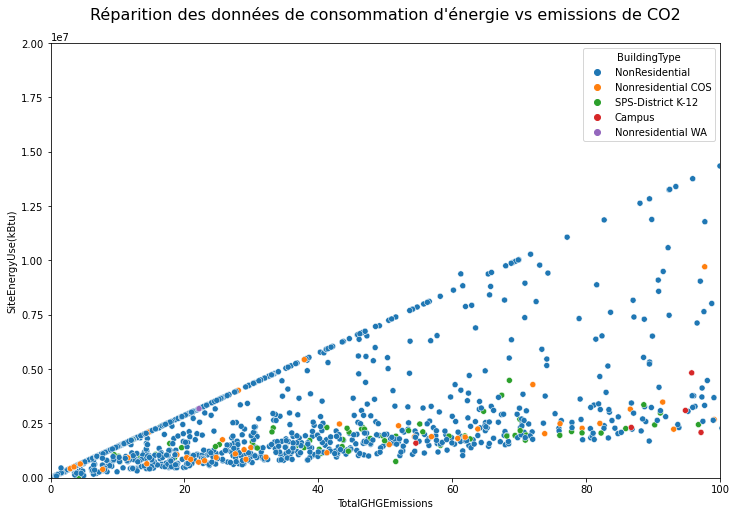

In [81]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Réparition des données de consommation d'énergie vs emissions de CO2\n", fontsize=16)
plt.ylim(0, 2*1e7)
plt.xlim(0, 100)
 
plt.show()

In [83]:
df[(df['SiteEnergyUse(kBtu)'] > 0.9*1e7) & (df['TotalGHGEmissions'] < 65)]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,BuildingAge,PropertyGFATotal_log,PropertyGFATotal_sqrt,PropertyGFATotal_square,GFAPerBuilding_log,GFAPerBuilding_sqrt,GFAPerBuilding_square,GFAParkingRate_log,GFAParkingRate_sqrt,GFAParkingRate_square,GFABuildingRate_log,GFABuildingRate_sqrt,GFABuildingRate_square,GFAPerFloor_log,GFAPerFloor_sqrt,GFAPerFloor_square
428,NonResidential,Large office,7,LAKE UNION,47.62029,-122.33078,2005,Office,1.0,6.0,336700.0,94.5,9378391.0,61.265,3,0.62934,0.37066,336700.0,56116.667,11,12.726948,580.258563,1.133669e+11,12.726948,580.258563,1.133669e+11,0.315292,0.608819,0.137389,-0.463084,0.79331,0.396069,10.935188,236.889567,3.149080e+09


In [84]:
df = df.drop(df[(df['SiteEnergyUse(kBtu)'] > 0.9*1e7) & (df['TotalGHGEmissions'] < 65)].index)

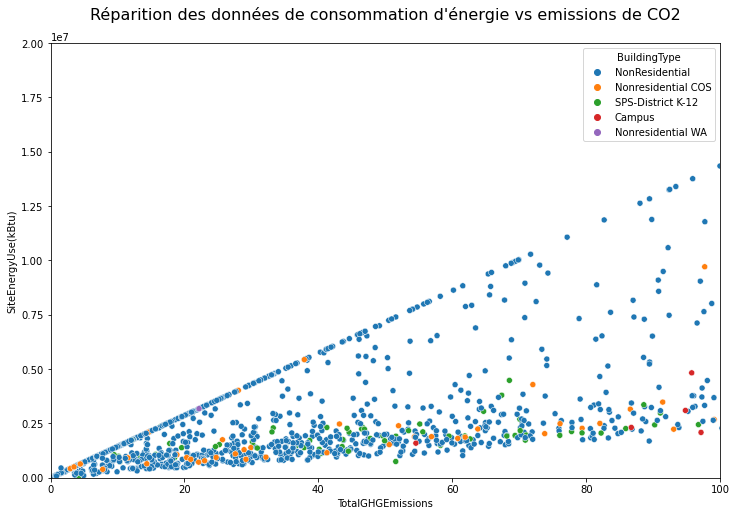

In [85]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Réparition des données de consommation d'énergie vs emissions de CO2\n", fontsize=16)
plt.ylim(0, 2*1e7)
plt.xlim(0, 100)
 
plt.show()

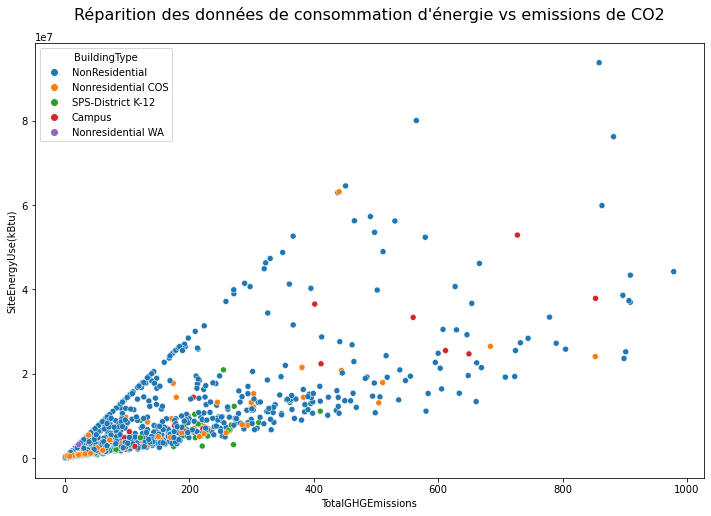

In [86]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = df, x='TotalGHGEmissions', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Réparition des données de consommation d'énergie vs emissions de CO2\n", fontsize=16)
plt.show()

Let's see the pairplots of the variables after outliers removal :

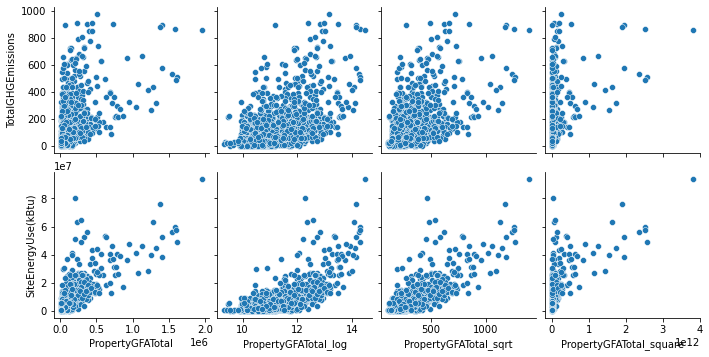

In [22]:
sns.pairplot(
    df,
    x_vars=["PropertyGFATotal",'PropertyGFATotal_log','PropertyGFATotal_sqrt','PropertyGFATotal_square'],
    y_vars=['TotalGHGEmissions','SiteEnergyUse(kBtu)'],
)

Overall, removing outliers has clarified the relationships and may lead to improved model performance by focusing on the typical emission and energy use patterns across buildings.

More transformed features below to allow the model to capture various forms of relationships, potentially improving its ability to generalize by testing both linear and non-linear patterns across the data :

In [23]:
df['GFAPerBuilding_log'] =  np.log(df['GFAPerBuilding']) 
df['GFAPerBuilding_sqrt'] =  np.sqrt(df['GFAPerBuilding'])
df['GFAPerBuilding_square'] =  np.square(df['GFAPerBuilding'])

df['GFAParkingRate_log'] =  np.log1p(df['GFAParkingRate']) 
df['GFAParkingRate_sqrt'] =  np.sqrt(df['GFAParkingRate'])
df['GFAParkingRate_square'] =  np.square(df['GFAParkingRate'])

df['GFABuildingRate_log'] =  np.log(df['GFABuildingRate'])  
df['GFABuildingRate_sqrt'] =  np.sqrt(df['GFABuildingRate'])
df['GFABuildingRate_square'] =  np.square(df['GFABuildingRate'])

df['GFAPerFloor_log'] =  np.log(df['GFAPerFloor']) 
df['GFAPerFloor_sqrt'] =  np.sqrt(df['GFAPerFloor'])
df['GFAPerFloor_square'] =  np.square(df['GFAPerFloor'])

checking for unusual or abnormal values after transformations

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DataYear,1652.0,2.015982e+03,1.335696e-01,2.015000e+03,2.016000e+03,2.016000e+03,2.016000e+03,2.016000e+03
CouncilDistrictCode,1652.0,4.357748e+00,2.195140e+00,1.000000e+00,2.000000e+00,4.000000e+00,7.000000e+00,7.000000e+00
Latitude,1652.0,4.761607e+01,4.848247e-02,4.749917e+01,4.758481e+01,4.761240e+01,4.764976e+01,4.773387e+01
Longitude,1652.0,-1.223330e+02,2.471097e-02,-1.224118e+02,-1.223435e+02,-1.223330e+02,-1.223214e+02,-1.222586e+02
YearBuilt,1652.0,1.961412e+03,3.281582e+01,1.900000e+03,1.930000e+03,1.965000e+03,1.989000e+03,2.015000e+03
NumberofBuildings,1652.0,1.070823e+00,7.052686e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e+01
NumberofFloors,1652.0,3.960351e+00,6.347816e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,9.900000e+01
PropertyGFATotal,1652.0,1.021880e+05,1.698857e+05,1.128500e+04,2.884700e+04,4.789950e+04,9.864250e+04,1.952220e+06
ENERGYSTARScore,1652.0,6.761077e+01,2.336212e+01,1.000000e+00,6.100000e+01,7.250000e+01,8.200000e+01,1.000000e+02
SiteEnergyUse(kBtu),1652.0,5.769554e+06,9.032946e+06,0.000000e+00,1.185701e+06,2.467800e+06,6.454912e+06,9.374886e+07


All looks good ! let's see the distribution of the variables after transformation :

<AxesSubplot:xlabel='PropertyGFATotal', ylabel='Count'>

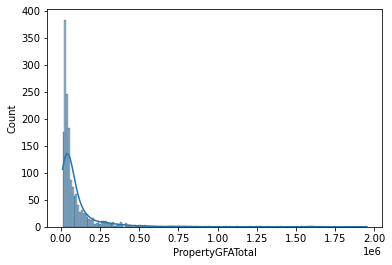

In [25]:
sns.histplot(data=df, x="PropertyGFATotal", kde=True)

<AxesSubplot:xlabel='PropertyGFATotal_log', ylabel='Count'>

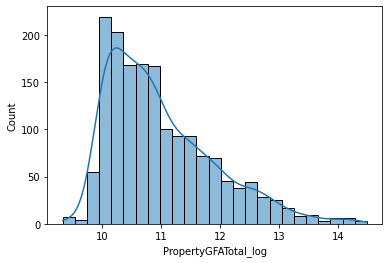

In [26]:
sns.histplot(data=df, x="PropertyGFATotal_log", kde=True)

The distribution appears right-skewed, but the log transformation has helped to reduce the initial skewness, creating a more compact and manageable range.

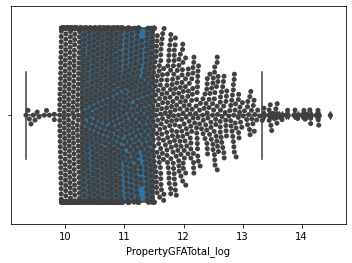

In [27]:
ax = sns.boxplot(x=df["PropertyGFATotal_log"])
ax = sns.swarmplot(x="PropertyGFATotal_log",data=df, color=".25")

The boxplot indicate a relatively compact distribution for `PropertyGFATotal_log`. The log transformation has effectively compressed the values, bringing the distribution closer to normal and reducing extreme outliers.

<AxesSubplot:xlabel='PropertyGFATotal_sqrt', ylabel='Count'>

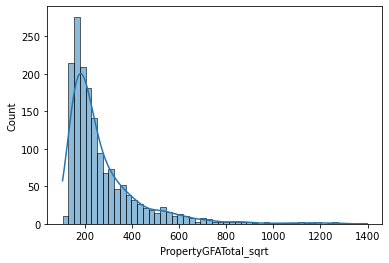

In [28]:
sns.histplot(data=df, x="PropertyGFATotal_sqrt", kde=True)

The distribution remains right-skewed, with a high concentration of values on the lower end and a long tail on the right. This suggests that the log transformation might be a better choice for modeling, as it provides a more compact and normal-like distribution

In [29]:
df = df.drop('DataYear',axis=1)

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

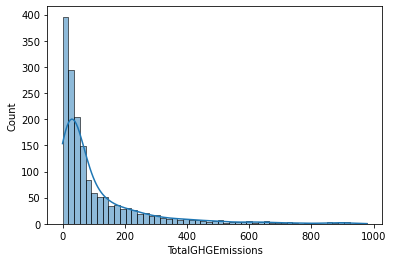

In [30]:
sns.histplot(data=df, x="TotalGHGEmissions", kde=True)

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

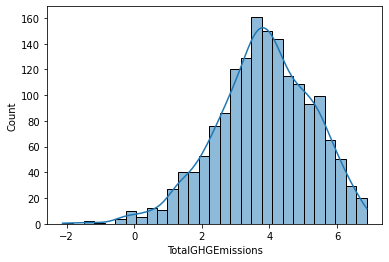

In [31]:
sns.histplot(data=df, x=np.log(df["TotalGHGEmissions"]), kde=True)

We see a better distribution with the log of `TotalGHGEmissions`

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Count'>

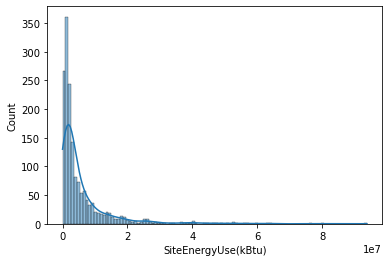

In [32]:
sns.histplot(data=df, x="SiteEnergyUse(kBtu)", kde=True)

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Count'>

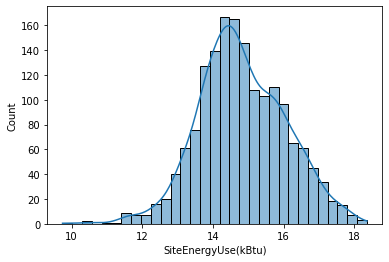

In [33]:
sns.histplot(data=df, x=np.log(df["SiteEnergyUse(kBtu)"]), kde=True)

We see also a better distribution with the log of `SiteEnergyUse(kBtu)`

Let's visualize the distribution of CO₂ emissions (`TotalGHGEmissions`) across different neighborhoods. 

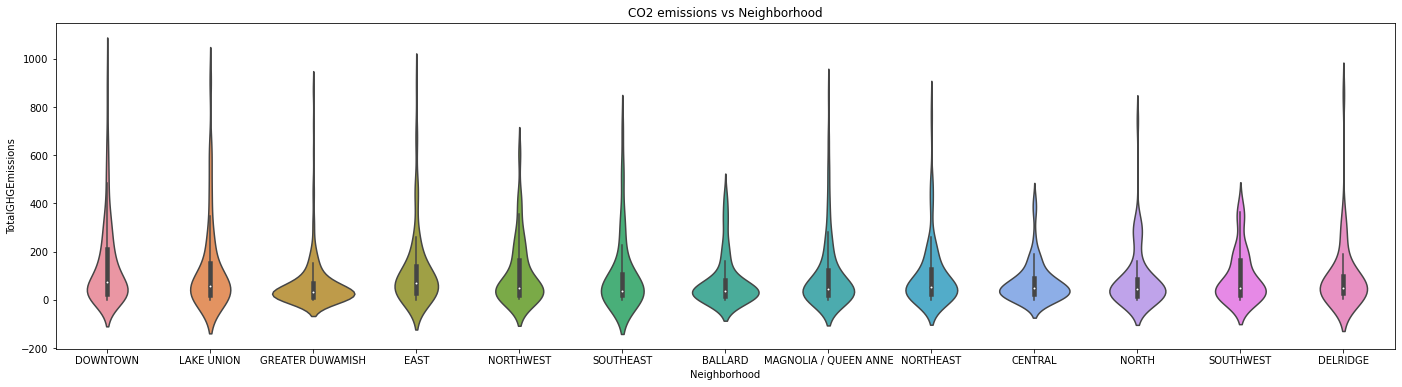

In [34]:
plt.figure(figsize=(24,6))
ax = sns.violinplot(x="Neighborhood", y="TotalGHGEmissions", data=df)
plt.title("CO2 emissions vs Neighborhood")
plt.show()

This analysis of CO₂ emissions by neighborhood shows:

- Variability across neighborhoods: Emission levels vary significantly by neighborhood, suggesting that location may influence emissions due to factors like building type or size.
- Distinct emission patterns: Neighborhoods like Downtown and Lake Union have broader distributions, indicating a mix of high and low-emission buildings.
- Modeling insight: Including neighborhood as a feature could improve model accuracy by accounting for location-based differences in emissions.

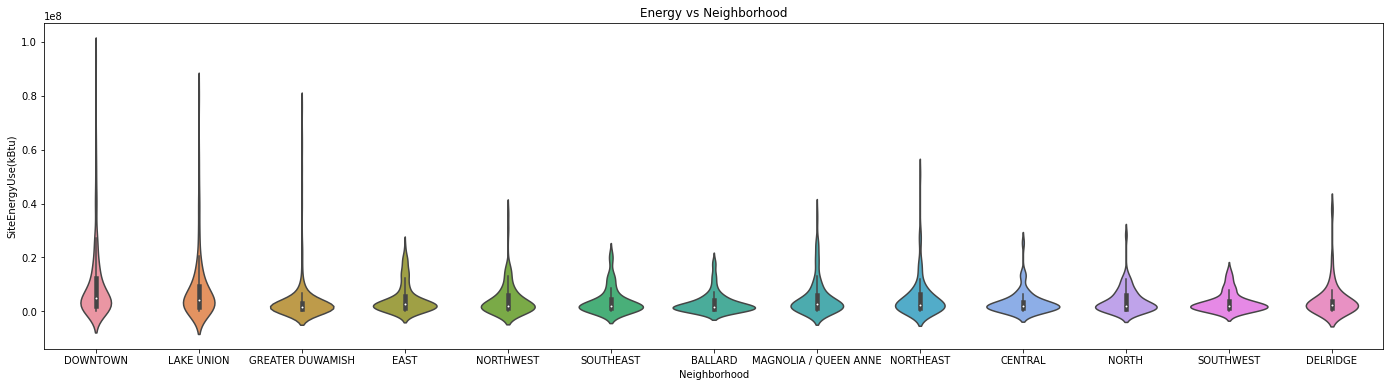

In [35]:
plt.figure(figsize=(24,6))
ax = sns.violinplot(x="Neighborhood", y="SiteEnergyUse(kBtu)", data=df)
plt.title('Energy vs Neighborhood')
plt.show()

In this violin plot, we're examining the distribution of energy consumption (`SiteEnergyUse(kBtu)`) across neighborhoods. Here’s what this analysis reveals:

- Variability across neighborhoods: Like CO₂ emissions, energy consumption also varies by neighborhood. Some areas, such as Downtown and Lake Union, show a broader range of values, indicating diverse energy use patterns within these neighborhoods.

- Concentration of energy Use: Some neighborhoods have narrow distributions, indicating that buildings in these areas consume energy within a smaller range. This could suggest more uniform building types or sizes.

- Modeling insight: The distribution differences across neighborhoods suggest that neighborhood might be an informative feature for predicting energy consumption, as it reflects location-based variations in energy use.

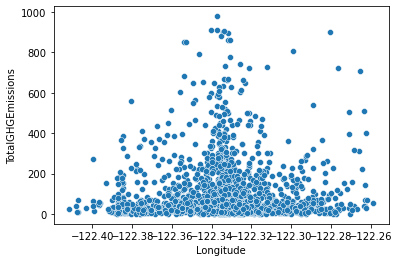

In [36]:
sns.scatterplot(data = df, x='Longitude', y='TotalGHGEmissions')
plt.show()

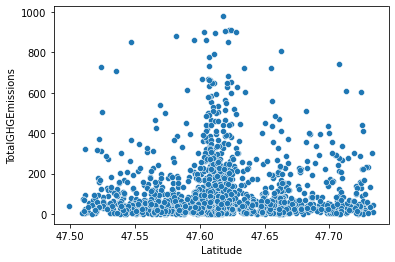

In [37]:
sns.scatterplot(data = df, x='Latitude', y='TotalGHGEmissions')
plt.show()

 Based on these above plots we can’t draw any strong conclusions about the relationship between location and emissions. The scatter plots don’t show a clear pattern or trend that would indicate a strong geographic influence on CO₂ emissions.

 We will now moving to the modeling phase: Encoding and Normalization

# Encoding et normalization

 The first step is to select numerical and categorical features:

Using make_column_selector, we identify numerical features (for scaling) and categorical features (for encoding) in our dataset.

In [38]:
from sklearn.compose import make_column_selector
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

With this setup, we can then create preprocessing pipelines for encoding and normalization:

- RobustScaler will be applied to numerical features to minimize the effect of outliers.
- OneHotEncoder will handle categorical features, preparing them for model input.

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

numerical_pipeline = make_pipeline(RobustScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))

In this step, we define a preprocessor using make_column_transformer, which combines:

- numerical_pipeline for scaling numerical features
- categorical_pipeline for encoding categorical features

This preprocessor streamlines data preparation by applying the correct transformations to each feature type before modeling.

In [40]:
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                       (categorical_pipeline, categorical_features))

In this step, we create models combined with a pipeline and preprocessor for consistent data encoding and scaling. These models (Linear Regression, Lasso, ElasticNet, XGBoost, and Random Forest) are now ready for training and selection based on performance.

In [41]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet 
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

LinearRegression = make_pipeline(preprocessor, LinearRegression())
Lasso = make_pipeline(preprocessor, Lasso())
ElasticNet = make_pipeline(preprocessor,  ElasticNet(random_state=0))
XGBRegressor = make_pipeline(preprocessor, XGBRegressor())
RandomForestRegressor = make_pipeline(preprocessor, RandomForestRegressor(random_state=0))

To prepare for model training and evaluation, we separate features (X) and targets (y) and perform a train/test split, using 80% of the data for training and 20% for testing. The shapes of the resulting datasets confirm the split, ensuring data consistency for model development.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
y = df[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train : ",X_train.shape)
print("X_test : ", X_test.shape)
print("y_train : ", y_train.shape)
print("y_test : ", y_test.shape)

X_train :  (1321, 33)
X_test :  (331, 33)
y_train :  (1321, 2)
y_test :  (331, 2)


# Models evaluation 

We create a custom function, evaluate_model, to better assess and select models by summarizing key performance metrics:

- Best Mean nMAE: Negative MAE is used for compatibility with scikit-learn, where higher scores indicate better performance. Taking the absolute value provides the true MAE.
- Best Mean R² Score: Shows the model’s fit quality, with higher values indicating a better model.
Average Fit Time: Provides the average computational time, helping balance accuracy with efficiency.
- est Hyperparameters: Displays the optimal settings from grid search for each model.

In [43]:
#fonction d'évaluation du modèle
def evaluate_model(model_grid, model_fit):
    df_results = pd.DataFrame.from_dict(model_grid.cv_results_).sort_values('rank_test_neg_mean_absolute_error')
    #-- best mean nMae--
    print('Best mean nMAE: {}'.format((model_fit.best_score_.round(2))))
    #-- best mean R² --
    print('Best mean R²: {}'.format(np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_r2']).round(2)))
    # fit_time:
    print('Fit time: {}s'.format(df_results.mean_fit_time.mean().round(2)))
    # parameters:
    print('\nBest parameters : {}\n'.format(model_fit.best_params_))
    return df_results

## Baseline : linear regression

Using GridSearchCV, we perform hyperparameter tuning for the Linear Regression model. 

The grid search is evaluated with 5-fold cross-validation, optimizing for both R² and negative MAE (neg_mean_absolute_error) to assess model fit and prediction accuracy. This process helps identify the optimal configuration for baseline performance.

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

#dictionnaire des hyperparamètres du modèle LinearRegression
param_lr = {"linearregression__fit_intercept": [True, False],
            "linearregression__normalize": [True, False]}

#Recherche des meilleurs hyperparamètres du modèle avec GridSearchCV :
lr_grid = GridSearchCV(LinearRegression,
                        param_lr,
                        cv=5, 
                        scoring=('r2','neg_mean_absolute_error'),
                        return_train_score = True,
                        refit='neg_mean_absolute_error',
                        n_jobs = -1)

In [45]:
lr_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A628330040>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A62831A4C0>)])),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearregression__normalize': [True, False]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'))

Training and displaying scores on the `TotalGHGEmissions` variable

In [46]:
lr_optimized_model_GHG = lr_grid.fit(X_train,y_train['TotalGHGEmissions'])
lr_results_GHG = evaluate_model(lr_grid,lr_optimized_model_GHG)

Best mean nMAE: -67.4
Best mean R²: 0.41
Fit time: 0.06s

Best parameters : {'linearregression__fit_intercept': False, 'linearregression__normalize': True}



Training and displaying scores on the `SiteEnergyUse(kBtu)` variable

In [47]:
lr_optimized_model_SEU = lr_grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
lr_results_SEU = evaluate_model(lr_grid,lr_optimized_model_SEU)

Best mean nMAE: -2920265.61
Best mean R²: 0.49
Fit time: 0.06s

Best parameters : {'linearregression__fit_intercept': False, 'linearregression__normalize': True}



The results show moderate predictive power with R² values below 0.5, indicating that linear regression captures some trends but may not fully explain the variance in emissions and energy use.

## Lasso

For the Lasso regression model, we use GridSearchCV to tune the following hyperparameters:
- alpha: Controls the strength of regularization, tested over a range from $10^{-5}$ to $10^{1}$
- max_iter: Specifies the maximum number of iterations, tested at 10, 100, and 1000 to ensure convergence.


In [48]:
#dictionnaire des hyperparamètres du modèle LinearRegression
param_lasso = {"lasso__alpha":np.logspace(-5, 1, num=20),
               "lasso__max_iter":[10,100,1000]}

lasso_grid = GridSearchCV(Lasso,
                        param_lasso,
                        cv=5, 
                        scoring=('r2','neg_mean_absolute_error'),
                        return_train_score = True,
                        refit='neg_mean_absolute_error',
                        n_jobs = -1)

In [49]:
np.logspace(-5, 1, num=20)

array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01])

In [50]:
lasso_optimized_model_GHG = lasso_grid.fit(X_train,y_train['TotalGHGEmissions'])
lasso_results_GHG = evaluate_model(lasso_grid,lasso_optimized_model_GHG)

Best mean nMAE: -64.96
Best mean R²: 0.52
Fit time: 0.19s

Best parameters : {'lasso__alpha': 0.26366508987303555, 'lasso__max_iter': 1000}



In [51]:
lasso_optimized_model_SEU = lasso_grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
lasso_results_SEU = evaluate_model(lasso_grid,lasso_optimized_model_SEU)

Best mean nMAE: -2693793.03
Best mean R²: 0.67
Fit time: 0.21s

Best parameters : {'lasso__alpha': 10.0, 'lasso__max_iter': 10}



These results indicate a slight improvement over linear regression (with R² increasing from 0.41 to 0.52), likely due to Lasso’s regularization, which reduces overfitting by penalizing less informative features. This regularization helps the model generalize better to unseen data.

To understand the impact of regularization in more detail, we now compute the baseline error for linear regression on the test set without regularization.

In [52]:
from sklearn import linear_model
import numpy as np

categorical_cols = df.select_dtypes(exclude=np.number)

# On crée un modèle de régression linéaire
lr1 = linear_model.LinearRegression()
lr2 = linear_model.LinearRegression()

# On entraîne ce modèle sur les données d'entrainement
lr1.fit(X_train.drop(columns=categorical_cols),y_train['TotalGHGEmissions'])
lr2.fit(X_train.drop(columns=categorical_cols),y_train['SiteEnergyUse(kBtu)'])

# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
baseline_error1 = np.mean((lr1.predict(X_test.drop(columns=categorical_cols)) - y_test['TotalGHGEmissions']) ** 2)
baseline_error2 = np.mean((lr2.predict(X_test.drop(columns=categorical_cols)) - y_test['SiteEnergyUse(kBtu)']) ** 2)

print(baseline_error1)
print(baseline_error2)

13330.607978629969
22404669869760.785


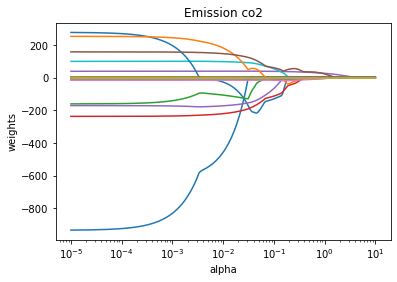

In [53]:
from sklearn import linear_model
n_alphas = 300
alphas = np.logspace(-5, 1, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)
coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train.drop(columns=categorical_cols), y_train['TotalGHGEmissions'])
    coefs.append(lasso.coef_)
    errors.append([baseline_error1, np.mean((lasso.predict(X_test.drop(columns=categorical_cols)) - y_test['TotalGHGEmissions']) ** 2)])
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Emission co2')
plt.axis('tight')
plt.show()    

This plot shows how increasing alpha impacts feature weights:
- Coefficient Shrinking: As alpha grows, less important feature weights approach zero, demonstrating Lasso’s feature selection.
- Feature Importance: Features that retain non-zero weights at higher alpha values are likely more predictive.
- Balancing Complexity and Accuracy: Lower alpha values keep more features (risking overfitting), while higher values retain only the most impactful ones, simplifying the model.

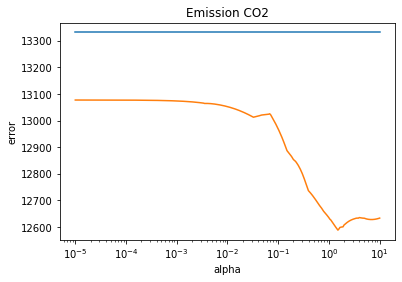

In [54]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.title('Emission CO2')
plt.show()

This plot shows how the error changes as alpha increases (blue curve at the top of the plot represents the baseline error) for Lasso regularization:

- Error reduction: As alpha increases, the error begins to decrease, indicating that Lasso is reducing overfitting by penalizing less relevant features.
- Plateau at higher alpha Values: At higher alpha values (around 10), the error reaches a plateau, suggesting that further regularization no longer significantly improves the error. This indicates that only the most important features remain in the model.
- Optimal alpha Choice: Intermediate values of alpha (around 10^0) around 1 appear to provide the best balance, minimizing error without overly penalizing key features. That is coherent with the alpha = 0.26 of above for CO2 emissions

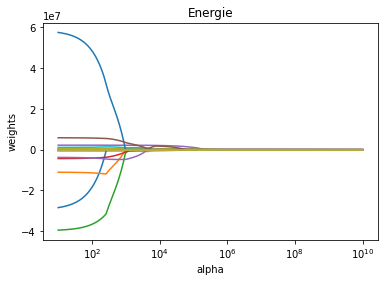

In [55]:
n_alphas = 300
alphas = np.logspace(10, 1, n_alphas)

coefs2 = []
errors2 = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train.drop(columns=categorical_cols), y_train['SiteEnergyUse(kBtu)'])
    coefs2.append(lasso.coef_)
    errors2.append([baseline_error2, np.mean((lasso.predict(X_test.drop(columns=categorical_cols)) - y_test['SiteEnergyUse(kBtu)']) ** 2)])
    
ax = plt.gca()

ax.plot(alphas, coefs2)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Energie')
plt.axis('tight')
plt.show()    

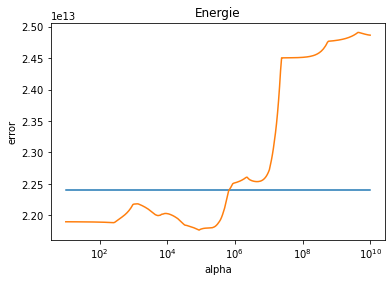

In [56]:
ax = plt.gca()

ax.plot(alphas, errors2)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.title('Energie')
plt.show()

GridSearchCV selected alpha = 10 as the best value because it likely provides a more stable and consistent performance across multiple validation folds. While alpha = 100 may appear to slightly reduce error in this specific plot, alpha = 10 likely achieves a better balance between bias and variance, leading to improved generalization on unseen data. This choice reflects a preference for stability over minimal error in isolated instances.

## Elastic Net

Here, we use GridSearchCV to optimize an Elastic Net model, which combines Lasso and Ridge penalties. The hyperparameters tuned are:

- alpha: Controls the strength of regularization.
- l1_ratio: Balances between Lasso (1.0) and Ridge (0.0) regularization.
- max_iter: Defines the maximum number of iterations for model convergence.

In [57]:
param_net = {"elasticnet__max_iter": [10,100,1000],
             "elasticnet__alpha": np.logspace(-4, 0, num=5),
             "elasticnet__l1_ratio": np.arange(0.0, 1.9, 0.1)}

net_grid = GridSearchCV( ElasticNet,
                            param_net,
                            cv=5, 
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)

In [58]:
net_optimized_model_GHG = net_grid.fit(X_train,y_train['TotalGHGEmissions'])
net_results_GHG = evaluate_model(net_grid,net_optimized_model_GHG)

Best mean nMAE: -64.74
Best mean R²: 0.53
Fit time: 0.13s

Best parameters : {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.4, 'elasticnet__max_iter': 1000}



In [59]:
net_optimized_model_SEU = net_grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
net_results_SEU = evaluate_model(net_grid,net_optimized_model_SEU)

Best mean nMAE: -2598781.48
Best mean R²: 0.68
Fit time: 0.14s

Best parameters : {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8, 'elasticnet__max_iter': 10}



The results show that Elastic Net achieved slightly better scores than previous models, with different optimal alpha and l1_ratio values for each target.

## XGBoost

In this section, we use GridSearchCV to tune the hyperparameters of an XGBoost model, key hyperparameters tuned include:

- learning_rate: Controls the step size at each iteration.
- max_depth: Limits the depth of each tree to prevent overfitting.
- min_child_weight: Defines the minimum sum of instance weight needed in a child.
- n_estimators: Sets the number of boosting rounds.

In [60]:
param_xgb = {'xgbregressor__learning_rate' : [0.01, 0.001],
             'xgbregressor__max_depth': [10,15],
             'xgbregressor__min_child_weight' : [6,3],
             'xgbregressor__n_estimators': [200,400]}

xgb_grid = GridSearchCV( XGBRegressor,
                            param_xgb,
                            cv=5, 
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)

In [61]:
xgb_optimized_model_GHG = xgb_grid.fit(X_train,y_train['TotalGHGEmissions'])
xgb_results_GHG = evaluate_model(xgb_grid,xgb_optimized_model_GHG)

Best mean nMAE: -63.34
Best mean R²: 0.48
Fit time: 8.16s

Best parameters : {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 10, 'xgbregressor__min_child_weight': 6, 'xgbregressor__n_estimators': 200}



In [62]:
xgb_results_GHG.iloc[:1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__learning_rate,param_xgbregressor__max_depth,param_xgbregressor__min_child_weight,param_xgbregressor__n_estimators,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,3.92457,0.475181,0.010409,0.00049,0.01,10,6,200,"{'xgbregressor__learning_rate': 0.01, 'xgbregr...",0.426614,0.35424,0.543627,0.380876,0.536104,0.448292,0.078308,5,0.813393,0.82145,0.811781,0.817934,0.809237,0.814759,0.004384,-69.856947,-66.581576,-58.054845,-69.714067,-52.481943,-63.337876,6.920078,1,-34.808428,-36.019459,-36.472525,-34.570604,-37.491936,-35.87259,1.079943


In [63]:
xgb_optimized_model_SEU = xgb_grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
xgb_results_SEU = evaluate_model(xgb_grid,xgb_optimized_model_SEU)

Best mean nMAE: -2396039.49
Best mean R²: 0.68
Fit time: 7.38s

Best parameters : {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 10, 'xgbregressor__min_child_weight': 3, 'xgbregressor__n_estimators': 400}



These results indicate a moderate fit, with the `SiteEnergyUse` model showing slightly better performance. for `TotalGHGEmissions`  Since our primary objective is prediction accuracy, we prioritize nMAE over R². Although XGBoost has a slightly lower R², it achieves a better nMAE, indicating more precise predictions on average. Therefore, XGBoost may be the better choice in this context, despite the additional training time.

## Random Forest

In [ ]:
param_rfr = {'randomforestregressor__n_estimators':[50, 100, 120],
             'randomforestregressor__max_features' : ['sqrt', 'log2'],
             'randomforestregressor__max_depth': [5,10,20],
             'randomforestregressor__min_samples_split': [1, 2, 3],
             'randomforestregressor__bootstrap' : [True, False],
             'randomforestregressor__min_samples_leaf': [1,2,3,4]}

rfr_grid = GridSearchCV(RandomForestRegressor,
                        param_rfr,
                        cv=5, 
                        scoring=('r2','neg_mean_absolute_error'),
                        return_train_score = True,
                        refit='neg_mean_absolute_error',
                        n_jobs = -1)

In [97]:
rfr_optimized_model_GHG = rfr_grid.fit(X_train,y_train['TotalGHGEmissions'])
rfr_results_GHG = evaluate_model(rfr_grid, rfr_optimized_model_GHG)

Best mean nMAE: -62.52
Best mean R²: 0.51
Fit time: 0.21s

Best parameters : {'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 120}



In [66]:
rfr_optimized_model_SEU = rfr_grid.fit(X_train,y_train['SiteEnergyUse(kBtu)'])
rfr_results_SEU = evaluate_model(rfr_grid, rfr_optimized_model_SEU)

Best mean nMAE: -2494502.66
Best mean R²: 0.68
Fit time: 0.22s

Best parameters : {'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 100}



The Random Forest model shows good performance on energy consumption prediction, particularly with a solid R² value of 0.68 and the best nMAE so far, suggesting it captures a significant portion of the variance and increase prediction accuracy especially for CO2. 

# Selection of the best models

## Model for predicting CO2 emissions

In [69]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']

GHG_compare_metrics = pd.concat([
           pd.DataFrame(lr_results_GHG[metrics].iloc[:1].mean(), columns=['LinearRegression (baseline)']),
           pd.DataFrame(lasso_results_GHG[metrics].iloc[:1].mean(), columns=['Lasso']),
           pd.DataFrame(net_results_GHG[metrics].iloc[:1].mean(), columns=['ElasticNet']),
           pd.DataFrame(xgb_results_GHG[metrics].iloc[:1].mean(), columns=['XGB']),
           pd.DataFrame(rfr_results_GHG[metrics].iloc[:1].mean(), columns=['RandomForest'])
          ], axis=1)

GHG_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['LinearRegression (baseline)','Lasso',
                                            'ElasticNet','XGB',
                                            'RandomForest'])
for m in metrics:
    GHG_final_metrics_compare[m] = GHG_compare_metrics.loc[m]

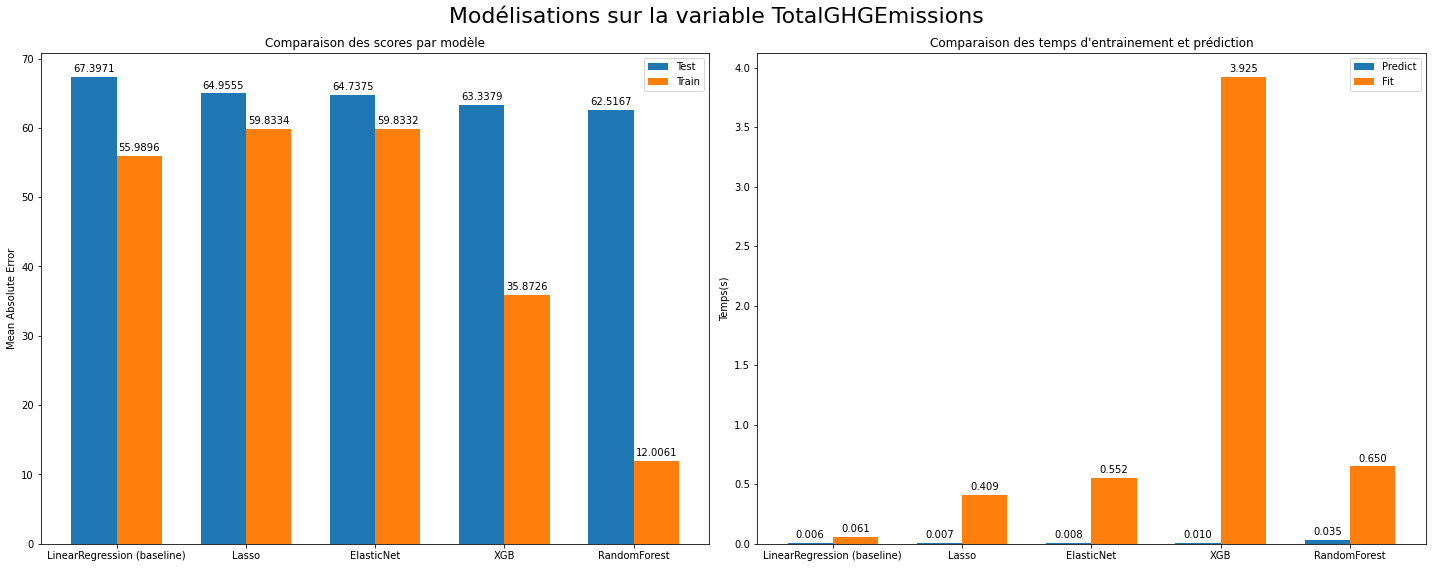

In [70]:
x = np.arange(len(GHG_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*GHG_final_metrics_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*GHG_final_metrics_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(GHG_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, GHG_final_metrics_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, GHG_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(GHG_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable TotalGHGEmissions", fontsize=22)
fig.tight_layout()

plt.show()

The chart on the left shows the Mean Absolute Error (MAE) for each model on the TotalGHGEmissions variable, with lower values indicating better accuracy. Random Forest achieved the lowest MAE (62.5) on test set, outperforming other models in terms of predictive accuracy.

The chart on the right compares the training and prediction times for each model. Although XGBoost also performed well in terms of error, it required significantly more time to train (1.97s), making it less efficient for practical use. **Random Forest** offers a strong balance between low error (high accuracy) and reasonable computation time (0.55s), making it the preferred model for this task.

## Importance des features C02 :

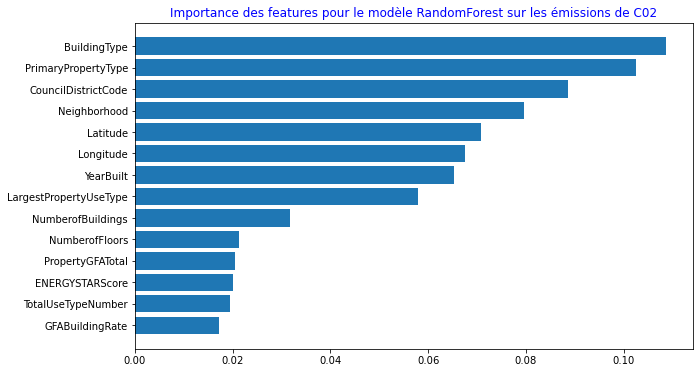

In [71]:
importances = rfr_optimized_model_GHG.best_estimator_.named_steps.randomforestregressor.feature_importances_
# Sort in ascending order
sorted_array = np.sort(importances)
# Reverse the sorted array
reverse_array = sorted_array[::-1]
# Select top ten features
reverse_array = reverse_array[:14]

indices = np.argsort(reverse_array)

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(range(len(reverse_array)), reverse_array[indices])
ax.set_yticks(range(len(reverse_array)))
ax.set_yticklabels(np.array(X_train.columns)[indices])
ax.set_title('Importance des features pour le modèle RandomForest sur les émissions de C02',color='b')
plt.show()

In analyzing feature importance using the Random Forest model on CO₂ emissions, the following insights emerge:

- Top Influential Features: `BuildingType`, `PrimaryPropertyType`, and `CouncilDistrictCode` are the most impactful features, indicating that the type and primary use of a building significantly influence emissions. This aligns with expectations, as different building functions typically have varied energy and emission profiles.

- Geographical Influence: `Neighborhood`, `Latitude`, and `Longitude` are notable factors, suggesting that emissions are affected by location, potentially due to climate, local regulations, or infrastructure differences across regions.

- Structural Characteristics: Features like `YearBuilt`, `NumberOfBuildings`, and `NumberOfFloors` also play a role, indicating that both the age and physical scale of buildings contribute to emissions levels.

`ENERGYSTARScore`: may not be essential for accurate CO₂ emissions predictions, and removing it could streamline the model without significantly affecting its performance.

## Modèle pour la prédiction de l'énergie

In [72]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_neg_mean_absolute_error',
           'mean_train_neg_mean_absolute_error']

SEU_compare_metrics = pd.concat([
           pd.DataFrame(lr_results_SEU[metrics].iloc[:1].mean(), columns=['LinearRegression (baseline)']),
           pd.DataFrame(lasso_results_SEU[metrics].iloc[:1].mean(), columns=['Lasso']),
           pd.DataFrame(net_results_SEU[metrics].iloc[:1].mean(), columns=['ElasticNet']),
           pd.DataFrame(xgb_results_SEU[metrics].iloc[:1].mean(), columns=['XGB']),
           pd.DataFrame(rfr_results_SEU[metrics].iloc[:1].mean(), columns=['RandomForest'])
          ], axis=1)

SEU_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['LinearRegression (baseline)','Lasso',
                                            'ElasticNet','XGB',
                                            'RandomForest'])
for m in metrics:
    SEU_final_metrics_compare[m] = SEU_compare_metrics.loc[m]

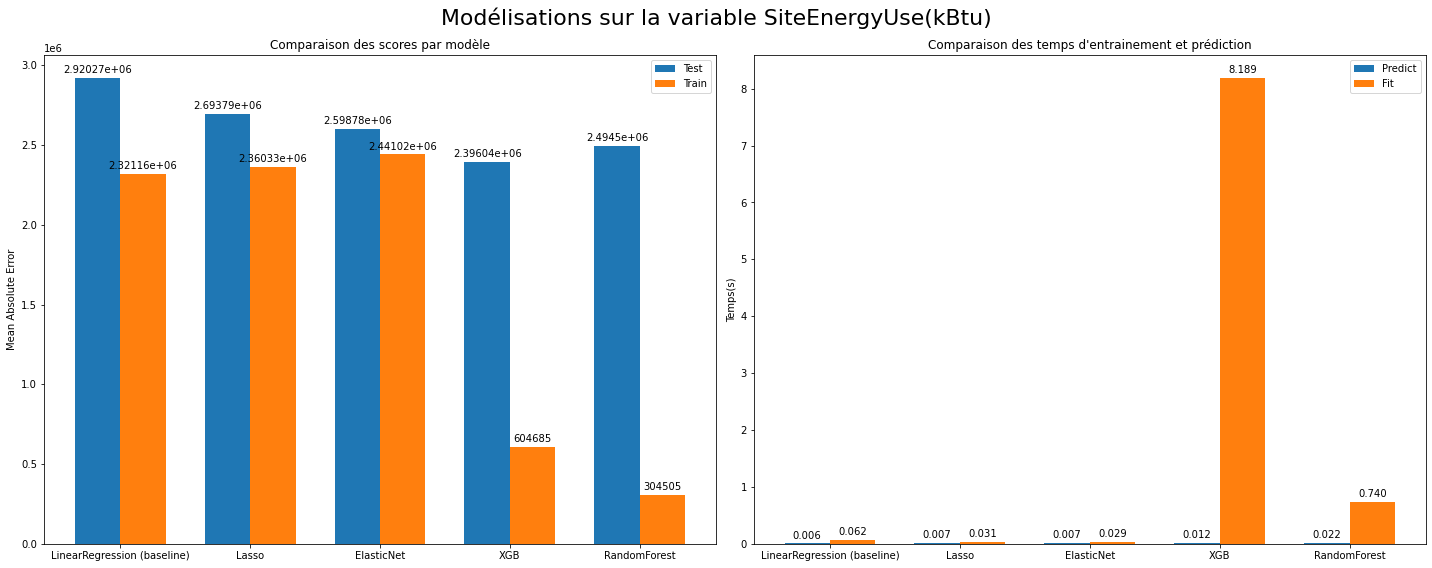

In [73]:
x = np.arange(len(SEU_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, -1*SEU_final_metrics_compare['mean_test_neg_mean_absolute_error'], width, label='Test')
scores2 = ax[0].bar(x + width/2, -1*SEU_final_metrics_compare['mean_train_neg_mean_absolute_error'], width, label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(SEU_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, SEU_final_metrics_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, SEU_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(SEU_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable SiteEnergyUse(kBtu)", fontsize=22)
fig.tight_layout()

plt.show()

In predicting `SiteEnergyUse (kBtu)`, XGBoost shows the best performance in terms of accuracy, with the lowest mean absolute error on test sets. However, its training time is considerably longer, making it less practical for this analysis. Random Forest provides a close balance with competitive accuracy and much faster training and prediction times, making it the preferred choice for a model that balances performance and efficiency.

## Importance des features SEU

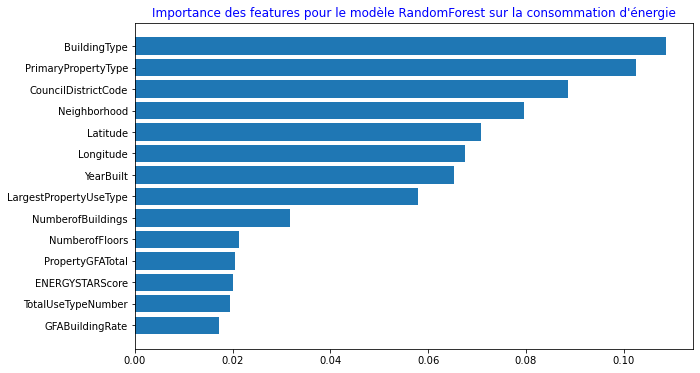

In [74]:
importances_SEU = rfr_optimized_model_SEU.best_estimator_.named_steps.randomforestregressor.feature_importances_
# Sort in ascending order
sorted_array = np.sort(importances_SEU)
# Reverse the sorted array
reverse_array = sorted_array[::-1]
# Select top ten features
reverse_array = reverse_array[:14]

indices = np.argsort(reverse_array)

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(range(len(reverse_array)), reverse_array[indices])
ax.set_yticks(range(len(reverse_array)))
ax.set_yticklabels(np.array(X_train.columns)[indices])
ax.set_title("Importance des features pour le modèle RandomForest sur la consommation d'énergie",color='b')
plt.show()

The feature importance analysis for predicting `SiteEnergyUse (kBtu)` with the Random Forest model reveals similar key variables to those identified in the CO₂ emissions prediction.

Again, `ENERGYSTARScore` shows minimal importance in this context, implying it has limited predictive value for energy consumption in this dataset. This suggests that excluding the ENERGY STAR score from data collection could be a viable cost-saving measure without significantly impacting model accuracy.

# Making predictions

## CO2 emissions prediction

In [75]:
X_test.shape

(331, 33)

In [76]:
def plot_pred_true(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred, color=color, alpha=.6)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réélles")
    plt.ylabel("Valeurs prédites")
    plt.title("Valeurs prédites VS valeurs réélles | Variable {}".format(title),fontsize=18)
    plt.show()

In [98]:
GHG_pred = rfr_optimized_model_GHG.predict(X_test)

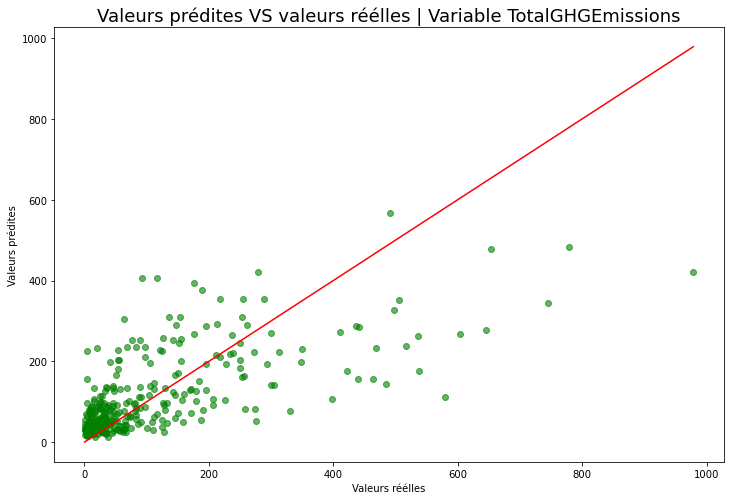

In [99]:
plot_pred_true(y_test['TotalGHGEmissions'],GHG_pred, color="g", title="TotalGHGEmissions")

The scatter plot shows the predicted vs. actual TotalGHGEmissions. Ideally, points should align along the red diagonal line, indicating that predictions are close to the true values.

We observe a concentration of points around lower emission values, with some spread and outliers as emissions increase. This suggests that the model performs reasonably well at predicting lower emissions but struggles more with higher values, leading to underestimation or overestimation in some cases.

In [108]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "R²"], "Résultats":[mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [109]:
#Calcul des métriques pour les émissions de CO2
GHGmetrics = metrics_model(y_test['TotalGHGEmissions'],GHG_pred)
GHGmetrics

,Métrique,Résultats
0,MAE,68.465627
1,R²,0.469389


- The Mean Absolute Error (MAE) is 68.47, indicating an average absolute difference of around 68 units between predicted and actual emission values.

- The R² score of 0.47 suggests that the model explains approximately 47% of the variance in the test data, which is a moderate level of fit. This R² score indicates that the model captures some of the underlying patterns in the data but has room for improvement, particularly in explaining variability in higher emission values.

## Energy consumption prediction

In [82]:
SEU_pred = rfr_optimized_model_SEU.predict(X_test)

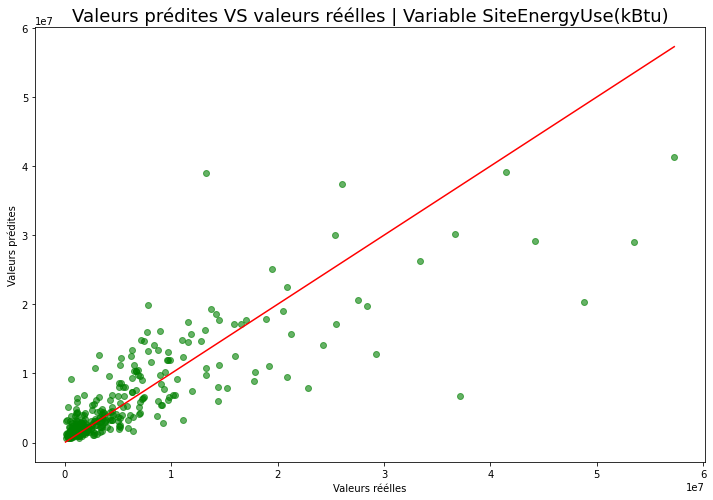

In [83]:
plot_pred_true(y_test['SiteEnergyUse(kBtu)'],SEU_pred, color="g", title="SiteEnergyUse(kBtu)")

This scatter plot illustrates the predicted values against actual values for `SiteEnergyUse(kBtu)`

Points that align closely with the red diagonal line indicate accurate predictions. However, there is visible dispersion, especially as energy use values increase, suggesting that the model struggles to maintain accuracy for higher energy consumption values.

In [84]:
SEUmetrics = metrics_model(y_test['SiteEnergyUse(kBtu)'],SEU_pred)
SEUmetrics

,Métrique,Résultats
0,MAE,2.546693e+06
1,R²,6.877536e-01


- The Mean Absolute Error (MAE) is approximately 2.55 million, indicating the average absolute difference between the predicted and actual energy usage values. This error magnitude reflects the challenge of accurately predicting energy use for larger values.
- The R² score is about 0.69, meaning the model explains around 69% of the variance in `SiteEnergyUse(kBtu)` in the test set. This is a reasonably good fit, suggesting that the model captures a substantial portion of the relationship between features and energy consumption, although there is room for improvement.

## **Without ENERGY STAR SCORE**

In [85]:
df2 = df.drop('ENERGYSTARScore', axis=1)

In [86]:
X2 = df2.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
y2 = df2[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [87]:
rfr_optimized_model_GHG2 = rfr_grid.fit(X_train2,y_train2['TotalGHGEmissions'])

In [88]:
GHG_pred2 = rfr_optimized_model_GHG2.predict(X_test2)

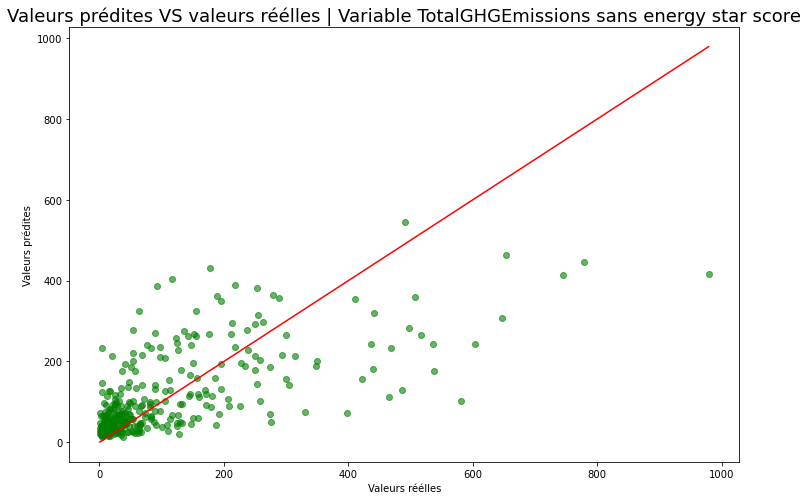

In [89]:
plot_pred_true(y_test['TotalGHGEmissions'],GHG_pred2, color="g", title="TotalGHGEmissions sans energy star score")

In [90]:
rfr_results_GHG2 = evaluate_model(rfr_grid, rfr_optimized_model_GHG2)

Best mean nMAE: -63.06
Best mean R²: 0.5
Fit time: 0.21s

Best parameters : {'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 120}



In [91]:
#Calcul des métriques pour les émissions de CO2
GHGmetrics2 = metrics_model(y_test['TotalGHGEmissions'],GHG_pred2)
GHGmetrics2

,Métrique,Résultats
0,MAE,70.25420
1,R²,0.44747


In [92]:
rfr_optimized_model_SEU = rfr_grid.fit(X_train2,y_train2['SiteEnergyUse(kBtu)'])

In [93]:
SEU_pred2 = rfr_optimized_model_SEU.predict(X_test2)

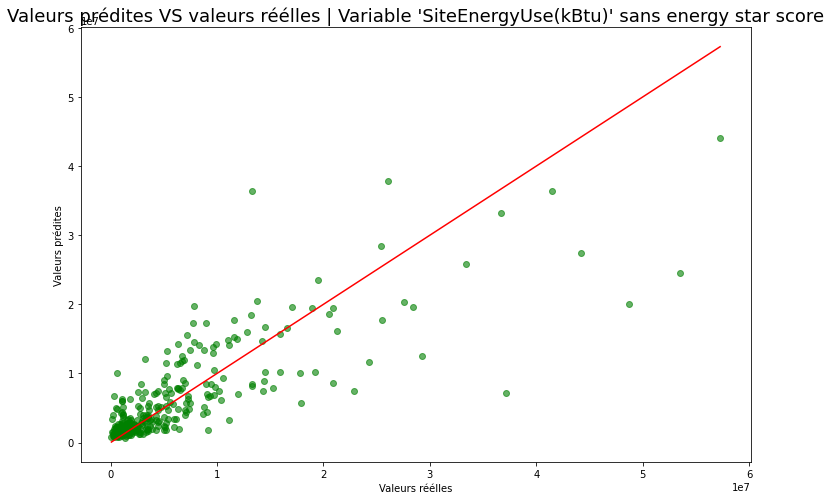

In [94]:
plot_pred_true(y_test['SiteEnergyUse(kBtu)'],SEU_pred2, color="g", title="'SiteEnergyUse(kBtu)' sans energy star score")

In [95]:
rfr_results_SEU = evaluate_model(rfr_grid, rfr_optimized_model_SEU)

Best mean nMAE: -2588641.1
Best mean R²: 0.67
Fit time: 0.21s

Best parameters : {'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 100}



In [96]:
#Calcul des métriques pour les émissions de CO2
SEUmetrics2 = metrics_model(y_test['SiteEnergyUse(kBtu)'],SEU_pred2)
SEUmetrics2

,Métrique,Résultats
0,MAE,2.677063e+06
1,R²,6.663626e-01


Based on the analysis without the ENERGYSTARScore variable, we observe the following:

1. `TotalGHGEmissions`:

- The nMAE slightly increased, suggesting a minor reduction in prediction accuracy. Previously, we had an nMAE of approximately -63.06, and now it stands at -70.25.
- The R² score also decreased marginally from 0.50 to 0.44, indicating a slight drop in the model's ability to explain the variance in CO₂ emissions.


2. `SiteEnergyUse(kBtu)`:

- For the energy consumption variable, removing ENERGYSTARScore resulted in an increase in nMAE from approximately -2.58 million to -2.67 million.
- Similarly, the R² score saw a minor decrease from 0.68 to 0.66, indicating a slight reduction in the model's explanatory power.

Conclusion: While there is a slight degradation in both nMAE and R² scores for both targets, the impact is relatively minor. This suggests that ENERGYSTARScore does provide some predictive value, but it may not be essential for the model. Removing it could be justified if the cost of acquiring this data is high, as the model remains reasonably accurate even without it.

# Conclusion

In this notebook, we focused on predicting CO₂ emissions (`TotalGHGEmissions`) and energy consumption (`SiteEnergyUse(kBtu)`) for buildings using several machine learning models, including Linear Regression, Lasso, Elastic Net, XGBoost, and Random Forest. Through our analysis, we observed the following key insights:

1. Model Selection and Performance:

- Random Forest emerged as the optimal choice for balancing prediction accuracy and computational efficiency, performing well across both targets with manageable training and prediction times.
- XGBoost showed potential in slightly reducing the nMAE, but its prolonged training time makes it less practical for applications requiring rapid model updates or predictions.
- Regularization techniques like Lasso and Elastic Net provided useful insights into feature importance by reducing overfitting and highlighting the most impactful variables.

2. Feature Importance and Cost Implications:

- The feature importance analysis identified that factors such as BuildingType, PrimaryPropertyType, and CouncilDistrictCode have a significant influence on both emissions and energy consumption predictions.
- Interestingly, `ENERGYSTARScore`, which measures a building's energy efficiency, was found to have minimal predictive value. Removing it from the models resulted in only a slight drop in accuracy. Given the high cost of collecting `ENERGYSTARScore` data, this finding suggests that it could be excluded in future modeling without substantially impacting prediction quality. This could lead to cost savings in data collection, especially for large datasets.

1. Opportunities for Improvement:

- Feature Engineering: Creating new features from existing data (e.g., polynomial features, interactions between variables, or logarithmic transformations) could capture more nuanced relationships and improve model accuracy without requiring additional data sources.
- Advanced Hyperparameter Tuning: While we applied basic hyperparameter tuning, exploring more extensive grids or using optimization techniques like Bayesian Optimization could help identify even better model configurations, especially for XGBoost and Random Forest.


Overall, this study highlights the feasibility of using machine learning to predict emissions and energy consumption based on building and location characteristics. By selecting features judiciously and optimizing model configurations, we can balance accuracy, computational cost, and data acquisition costs, providing a practical framework for sustainable predictive modeling in this domain.